In [107]:
import numpy as np
import matplotlib.pyplot as plot
import math

In [108]:
class currents:
    def I_sine(t):
        return 20* (math.sin(t*0.5) + 1.5)

    def I_constant(t):
        return 50

    def I_step(t):
        if t > 20 and t <= 50:
            return 0
        return 5    

    def I_linear(t):
        return 10*t - 2.5  

    def I_polonomyal(t):
        return 2*(t**2) - 3*t + 5

In [109]:
class LIF:
    def __init__(self, I, T=100, dt=0.1,V_threshold=-50, V_rest=-70, V=-100, V_reset=-65, V_spike=10, g=10, 
    tau=8, tau_k=1, neuron_type='excitatory') :
        self.T = T
        self.dt = dt
        self.tau = tau
        self.tau_k = tau_k
        self.g = g
        self.V_rest = V_rest
        self.V_threshold = V_threshold
        self.V_reset = V_reset
        self.V_spike = V_spike
        self.max_currents = {}
        self.neuron_type = neuron_type
        self.times = []
        self.I = I
        self.V = V
        self.count = 0
        self.V_t = []

    def start(self):
        t = 0
        while t <= self.T:
            du = (-(self.V - self.V_rest) + self.I(t) * self.g)* (self.dt/self.tau)

            self.V += du * self.dt
            is_spike = False
            if self.V >= self.V_threshold:
                self.V_t.append(self.V + self.V_spike)
                self.count += 1
                self.V = self.V_reset
                is_spike = True

            else:
                self.V_t.append(self.V)
            t += self.dt

            yield {'u': self.V, 'is_spike': is_spike}

    def V_plot(self):
        plot.plot(list(map(lambda i: i * self.dt, range(len(self.V_t)))), self.V_t)
        plot.show()

    def V_t(self, times, I):
        V=[]
        V.append(self.V_rest)
        self.max_currents[str(I.__name__)] = I(times[0])
        for i in range(1, len(times)):
            if I(times[i]) > self.max_currents[str(I.__name__)]:
                self.max_currents[str(I.__name__)] = I(times[i])
            V.append(((-1 * (V[i-1]- self.V_rest)) + (self.R * I(times[i])) * self.dt/self.tau)+ V[i-1])
            if V[i] >= self.V_threshold:
                    V[i] = self.V_rest
                    V[i-1] = self.V_spike
        return V            
        
        
    def plot(self, I):
        self.times = np.linspace(0, self.T, int(self.T/self.dt))
        plot.figure(figsize=(15, 10))
        plot.title('LIF')
        plot.suptitle("R: " + str(self.R) + "\ntotal time: " + str(self.T) + "\ndt: " + str(self.dt) +
                    "\nV_threshold: " + str(self.V_threshold) + "\nV_rest: " + str(self.V_rest) + "\nV_spike: " + str(self.V_spike) + 
                    "\nI: " + (str(I.__name__)), fontsize=12, ha = 'left', x=0.95, y=1)        
        plot.plot(self.times, self.V_t(self.times, I))
        plot.xlabel('Time(t)')
        plot.ylabel('Potential(v)')
        plot.show()           

In [110]:
class connection:
    def __init__(self, neurons, connections, we, wi, e_delay,
               i_delay, count):
      self.neurons = neurons
      self.connections = connections
      self.we = we
      self.wi = wi
      self.e_delay = e_delay
      self.i_delay = i_delay
      self.count = count
      self.actions = self.init_actions()

      self.spikes = []
      self.e_spikes_time = []
      self.e_spikes = []
      self.i_spikes_time = []
      self.i_spikes = []
      self.spikes_effect = []

    def init_actions(self):
      actions = []
      for i in self.neurons:
        actions.append(i.start())
      return actions

    def start(self):
      self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.count)]
      for i in range(self.count):
        for j in range(len(self.actions)):
          info = next(self.actions[j])
          if info['is_spike'] == True :
            for z in self.connections[j]:
              if self.neurons[j].neuron_type == 'excitatory':
                self.e_spikes.append(j + 1)
                self.e_spikes_time.append(i)
                if i + self.e_delay < self.count:
                  self.spikes_effect[i + self.e_delay][z] += self.we

              if self.neurons[j].neuron_type == 'inhibitory':
                self.i_spikes.append(j + 1)
                self.i_spikes_time.append(i)
                if i+self.i_delay < self.count:
                  self.spikes_effect[i+self.i_delay][z] += self.we
        for k in range(len(self.neurons)):
            self.neurons[k].V += self.spikes_effect[i][k]
      

    def u_plot(self, neurons_count=2):
      legend = []
      for i in range(min(neurons_count, len(self.neurons))):
        plot.plot(list(map(lambda j: j * self.neurons[i].dt, range(len(self.neurons[i].V_t)))), self.neurons[i].V_t)
        legend.append('neuron ' + str(i+1))
      plot.legend(legend)

    def plot(self):
      plot.scatter(self.e_spikes_time, self.e_spikes)
      plot.scatter(self.i_spikes_time, self.i_spikes)
      plot.legend(['excitatory', 'inhibitory'])


2 excitatory

Text(0, 0.5, 'I')

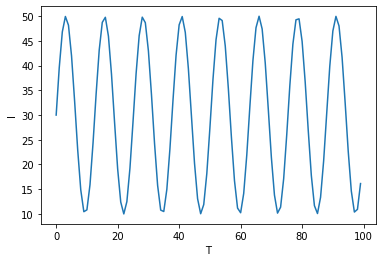

In [111]:
neuron1 = LIF(I=currents.I_sine)
plot.plot(range(100), list(map(currents.I_sine, range(100))))
plot.xlabel('T')
plot.ylabel('I')

Text(0, 0.5, 'Input Current(mV)')

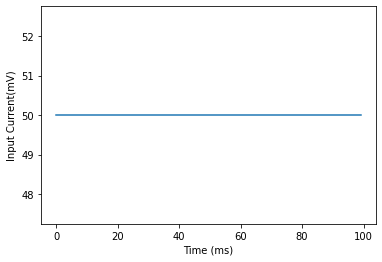

In [112]:
neuron2 = LIF(I=currents.I_constant)
plot.plot(range(100), list(map(currents.I_constant, range(100))))
plot.xlabel('Time (ms)')
plot.ylabel('Input Current(mV)')

In [113]:
neurons = [neuron1, neuron2]
connections = [[1], [0]]
group = connection(neurons, connections, 1.5, 1.5, 1, 1, 500)
group.start()

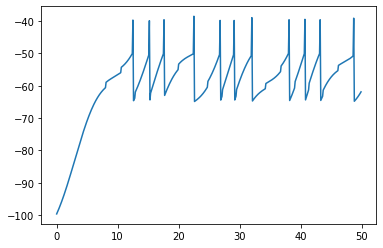

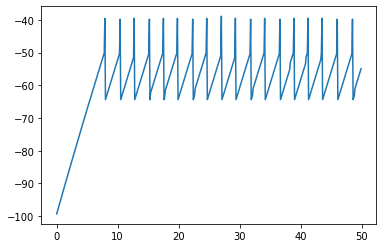

In [114]:
neuron1.V_plot()
neuron2.V_plot()

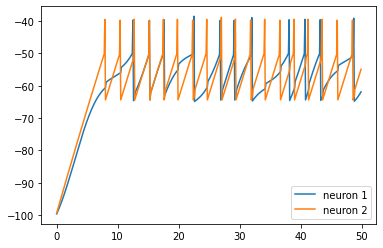

In [115]:
group.u_plot()

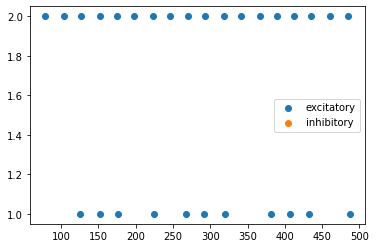

In [116]:
group.plot()

1 excitatory 1 inhibitory

Text(0, 0.5, 'I')

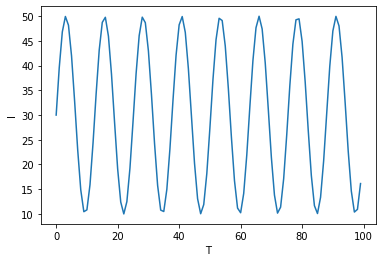

In [117]:
neuron1 = LIF(I=currents.I_sine)
plot.plot(range(100), list(map(currents.I_sine, range(100))))
plot.xlabel('T')
plot.ylabel('I')

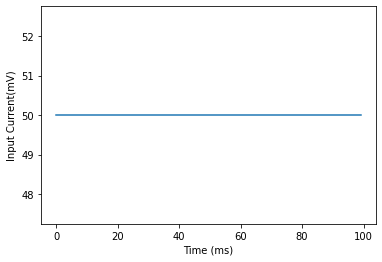

In [118]:
neuron2 = LIF(I=currents.I_constant, neuron_type='inhibitory')
plot.plot(range(100), list(map(currents.I_constant, range(100))))
plot.xlabel('Time (ms)')
plot.ylabel('Input Current(mV)')

neurons = [neuron1, neuron2]
connections = [[1], [0]]
group = connection(neurons, connections, 1.5, 1.5, 1, 1, 500)
group.start()

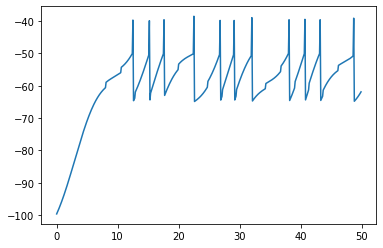

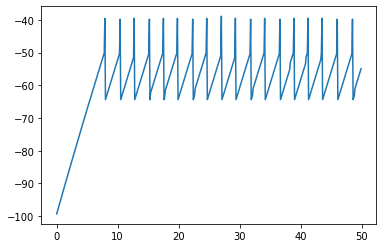

In [119]:
neuron1.V_plot()
neuron2.V_plot()

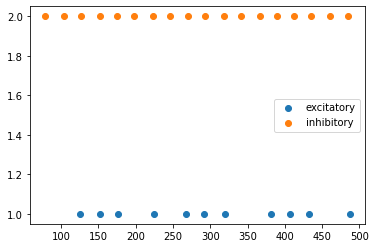

In [120]:
group.plot()

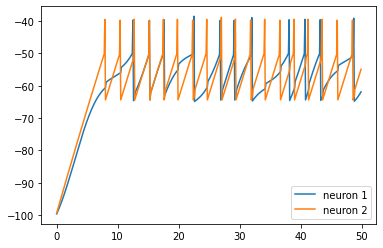

In [121]:
group.u_plot()

2 inhibitory

Text(0, 0.5, 'I')

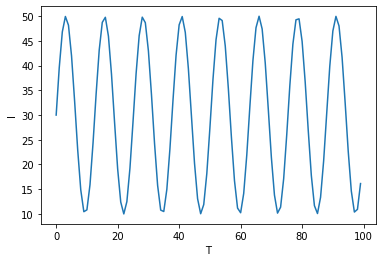

In [122]:
neuron1 = LIF(I=currents.I_sine, neuron_type='inhibitory')
plot.plot(range(100), list(map(currents.I_sine, range(100))))
plot.xlabel('T')
plot.ylabel('I')

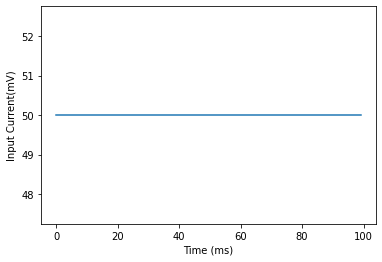

In [123]:
neuron2 = LIF(I=currents.I_constant, neuron_type='inhibitory')
plot.plot(range(100), list(map(currents.I_constant, range(100))))
plot.xlabel('Time (ms)')
plot.ylabel('Input Current(mV)')

neurons = [neuron1, neuron2]
connections = [[1], [0]]
group = connection(neurons, connections, 1.5, 1.5, 1, 1, 500)
group.start()

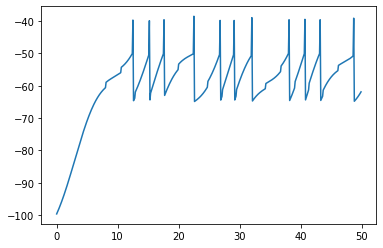

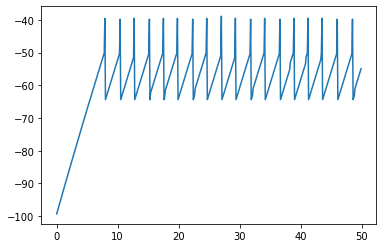

In [124]:
neuron1.V_plot()
neuron2.V_plot()

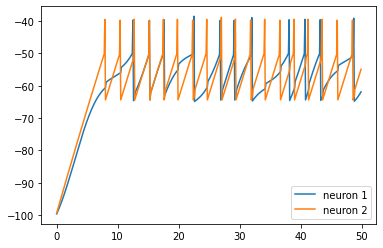

In [125]:
group.u_plot()

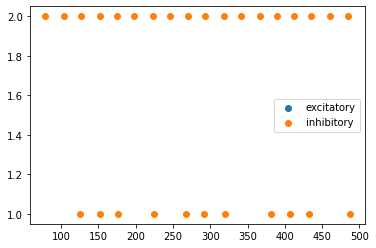

In [126]:
group.plot()

In [127]:
neuron1 = LIF(currents.I_constant)
neuron2 = LIF(currents.I_constant)
neuron3 = LIF(currents.I_constant)
neuron4 = LIF(currents.I_constant, neuron_type='inhibitory')

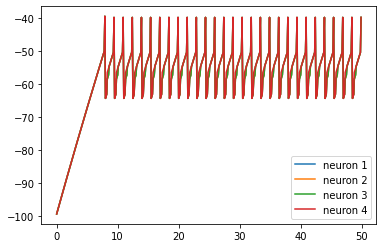

In [128]:
neurons = [neuron1, neuron2, neuron3, neuron4]
connections = [[1, 2, 3], [0, 2, 3], [0, 1, 3], [0, 1, 2]]
group = connection(neurons, connections, we=2, wi = 1, e_delay=3, i_delay=6, count=500)
group.start()
group.u_plot(neurons_count=4)

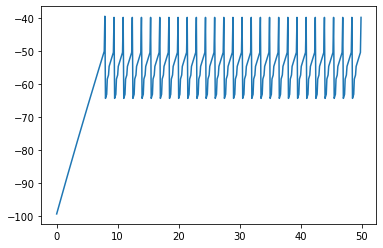

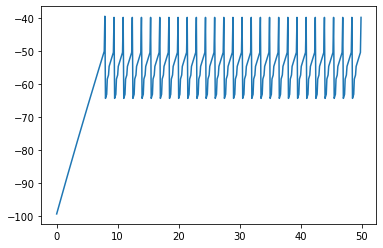

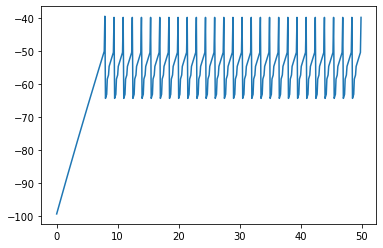

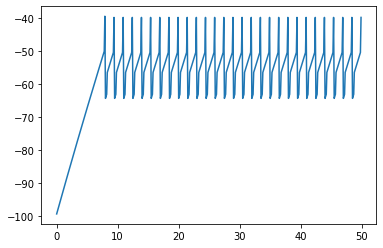

In [129]:
neuron1.V_plot()
neuron2.V_plot()
neuron3.V_plot()
neuron4.V_plot()

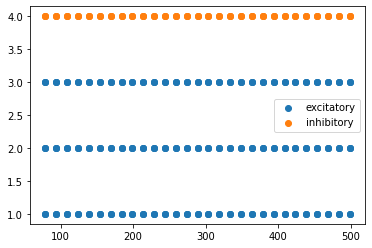

In [130]:
group.plot()

In [131]:
import random
def create_neurons_group(count, p_e, p_c, I_e, I_i):

    neurons = []
    connections = []
    
    n_e = math.floor(p_e*count)
    n_i = count - n_e
    n_connections = p_c * (count-1)

    for i in list(range(count)):
        if i < n_i:
            neurons.append(LIF(I=I_i, neuron_type= 'inhibitory'))
        else :
            neurons.append(LIF(I_e))
        connections.append(random.sample(list(range(0, i)) + list(range(i+1, count)), n_connections))
    return neurons, connections   

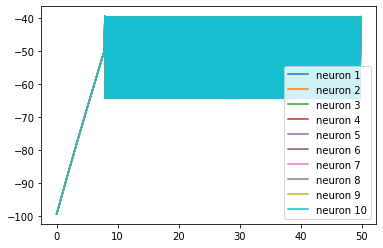

In [132]:
neurons, connections = create_neurons_group(10, 1.5, 1, currents.I_constant, currents.I_constant)
group = connection(neurons, connections, 1.5, 1.5, 1, 1, 500)
group.start()
group.u_plot(neurons_count=10)

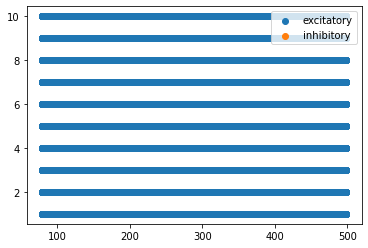

In [133]:
group.plot()